# Load Data

In [1]:
from data import TwitterP
import numpy as np
from tqdm import trange

In [2]:
trainT, validationT, testT = TwitterP.load_data()

Data has apparently already been downloaded and unpacked.


In [3]:
df=trainT.append(validationT)
df=df.append(testT)

In [4]:
Negative_tweets=[]
Positive_tweets=[]
n_private=0
for i in trange(1,len(df)):
    timeline = TwitterP.get_username_profile(df['username'].iloc[i])
    if df["Positive"][i]==1:
        if (timeline.empty):
            n_private+=1
        else:
            Positive_tweets=np.append(Positive_tweets,timeline.tweet)
    if df["Negative"][i]==1:
        if (timeline.empty):
            n_private+=1
        else:
            Negative_tweets=np.append(Negative_tweets,timeline.tweet)

100%|██████████| 5459/5459 [01:04<00:00, 84.73it/s] 


In [5]:
PL = [1] * len(Positive_tweets) 
NL = [0] * len(Negative_tweets) 

In [6]:
len(Positive_tweets), len(Negative_tweets) 

(223014, 187360)

In [6]:
x=np.append(Positive_tweets[10001:15000],Negative_tweets[10001:15000])
y=np.append(PL[10001:15000],NL[10001:15000])

In [9]:
# we shuffle our sorted data, to make it random first
indices = np.arange(x.shape[0])
np.random.shuffle(indices)
x = x[indices]
y = y[indices]

In [10]:
import pandas as pd 
d = {'Tweet':x,'label':y}
df = pd.DataFrame(d)


In [11]:
df.to_csv('test_data.csv', index=False)

In [7]:
x=np.append(Positive_tweets[0:10000],Negative_tweets[0:10000])
y=np.append(PL[0:10000],NL[0:10000])

In [8]:
import os
import numpy as np
# NumPy is a very widely-used library in Python for mathematical operations.
# It supports many complex mathematical functions and can work on large arrays and matrices.

embeddings_index = {}
with open(os.path.join('glove.6B.100d.txt')) as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

print("Found {} word vectors.".format(len(embeddings_index)))

Found 400000 word vectors.


In [9]:
# to see what word embeddings look like
embeddings_index["depressed"]

array([-0.067077,  0.34271 ,  0.31389 ,  0.45675 , -1.0441  , -0.30359 ,
       -0.72071 ,  0.024742,  1.0052  , -0.30277 , -0.61816 ,  0.1482  ,
        0.55835 , -0.74295 ,  0.10714 ,  0.22635 , -0.99951 , -0.54721 ,
        0.73511 ,  0.40552 ,  0.71583 ,  0.37093 ,  0.017737,  0.56344 ,
       -0.086712, -0.19697 ,  0.16806 , -0.67181 , -0.16957 ,  1.233   ,
        0.40425 ,  0.39286 ,  0.09856 , -0.39293 , -0.56219 ,  0.25364 ,
        0.19299 ,  0.17292 ,  0.40808 , -0.32074 , -0.082906, -0.59409 ,
        0.10728 , -0.28854 ,  0.11224 ,  0.30465 ,  0.75957 ,  0.91237 ,
        0.54494 , -0.89268 , -0.66143 , -0.24641 ,  0.053331,  0.20658 ,
       -0.021297, -0.97389 ,  0.55199 , -0.34674 ,  0.58749 , -0.023662,
        0.55734 ,  0.55996 , -0.63015 , -0.15025 , -0.15092 ,  0.11918 ,
        1.0616  , -0.29991 ,  0.38754 , -0.48744 ,  0.29452 , -0.42888 ,
       -0.031931,  0.49391 ,  0.31056 ,  0.18853 ,  0.28281 ,  0.1583  ,
        0.046716, -0.66058 ,  0.055853,  0.95369 , 

### Prepare Model:

In [10]:
import sys

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Input, LSTM, Embedding, Bidirectional, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import Constant

In [11]:
# Setting some parameters

MAX_SEQUENCE_LENGTH = 200 # determines how many words of every tweet will be processed
# if the tweet length is smaller than this, the tweet will be padded until it has a length equivalent to this

MAX_NUM_WORDS = 70000 # how many unique words in the training text to be tokenised
EMBEDDING_DIM = 100 # number of dimensions in the word embeddings
TRAINING_SPLIT = 0.8 # proportion of data to be used to training

In [12]:
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(x)
sequences = tokenizer.texts_to_sequences(x)
word_index = tokenizer.word_index

print("{} distinct words in original text".format(len(word_index)))

59179 distinct words in original text


99

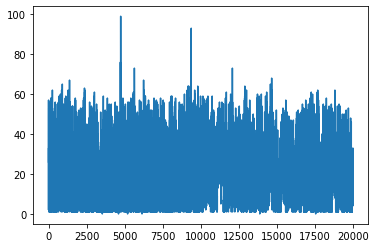

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline
seq_lengths = [len(x) for x in sequences]
plt.plot(seq_lengths)
max(seq_lengths)

In [14]:
MAX_SEQUENCE_LENGTH = max(seq_lengths)

data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

In [15]:
labels = to_categorical(np.asarray(y))
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

Shape of data tensor: (20000, 99)
Shape of label tensor: (20000, 2)


In [16]:
print(MAX_SEQUENCE_LENGTH)

99


In [15]:

# we shuffle our sorted data, to make it random first
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

# before we begin to split them
num_training_samples = int(TRAINING_SPLIT * data.shape[0])

In [16]:
x_train = data[:num_training_samples]
y_train = labels[:num_training_samples]
x_val = data[num_training_samples:]
y_val = labels[num_training_samples:]

## Prepare embedding:

In [17]:
num_words = min(MAX_NUM_WORDS, len(word_index)) + 1
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word_index.items():
    if i > MAX_NUM_WORDS:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

# load pre-trained word embeddings into an Embedding layer
# note that we set trainable = False so as to keep the embeddings fixed
embedding_layer = Embedding(num_words,
                            EMBEDDING_DIM,
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

In [18]:
#Model
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
x = Bidirectional(LSTM(256))(embedded_sequences)
y = Dropout(0.5)(x)

preds = Dense(labels.shape[1], activation='softmax')(y)
model = Model(sequence_input, preds)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [19]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 99)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 99, 100)           5918000   
_________________________________________________________________
bidirectional (Bidirectional (None, 512)               731136    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 2)                 1026      
Total params: 6,650,162
Trainable params: 732,162
Non-trainable params: 5,918,000
_________________________________________________________________


In [20]:
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

checkpoint = ModelCheckpoint("best_weights.hdf5", monitor='val_acc', verbose=1, save_best_only=True, mode='max')
earlystopping = EarlyStopping(patience=4, monitor='acc')
callbacks = [earlystopping, checkpoint]

model.fit(x_train, y_train,
          batch_size=32,
          epochs=50,
          validation_data=(x_val, y_val),
          callbacks=callbacks,
          verbose=2)

model.load_weights("best_weights.hdf5")

print("DONE")

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 16000 samples, validate on 4000 samples
Epoch 1/50


In [ ]:
def predict_tweet(text_to_predict):
    test_sequence = tokenizer.texts_to_sequences([text_to_predict])
    test_data = pad_sequences(test_sequence, maxlen=MAX_SEQUENCE_LENGTH)
    predictions = model.predict(test_data)
    prediction = np.argmax(predictions)
    print("The person who tweeted this is {}\n".format(classes_index[prediction]))
    ranking = predictions.argsort()[-6:][::-1]
    for i in reversed(range(0, 6)):
        rank = ranking[0][i]
        print("{:>10} : {:.5f}%".format(classes_index[rank], predictions[0][rank]*100))

In [ ]:
predict_tweet("If I just disappear from the world right now, will anyone even care?")